<a href="https://colab.research.google.com/github/fjadidi2001/DataScienceJourney/blob/master/PINNs_S4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


In [ ]:
# Load the dataset
california = fetch_california_housing()

# Convert to DataFrame for better visualization
df = pd.DataFrame(california.data, columns=california.feature_names)
df['Target'] = california.target

df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [ ]:
# Split the data into features (X) and target (y)
X = df.drop('Target', axis=1)
y = df['Target']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
# Create the model
model = models.Sequential()

# Add layers
model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [ ]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                     │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,801 (18.75 KB)

 Trainable params: 4,801 (18.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32)


Epoch 1/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.6933 - mae: 0.8996 - val_loss: 0.4718 - val_mae: 0.4966
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4266 - mae: 0.4608 - val_loss: 0.4083 - val_mae: 0.4475
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3680 - mae: 0.4296 - val_loss: 0.3857 - val_mae: 0.4357
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3538 - mae: 0.4216 - val_loss: 0.3924 - val_mae: 0.4224
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3528 - mae: 0.4139 - val_loss: 0.3483 - val_mae: 0.4107
Epoch 6/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3330 - mae: 0.4033 - val_loss: 0.3397 - val_mae: 0.4149
Epoch 7/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3161 - mae: 0.3904 - val_loss: 0.3312 - val_mae: 0.4048
Epoch 8/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2999 - mae: 0.3845 - val_loss: 0.3226 - val_mae: 0.3866
Epoch 9/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

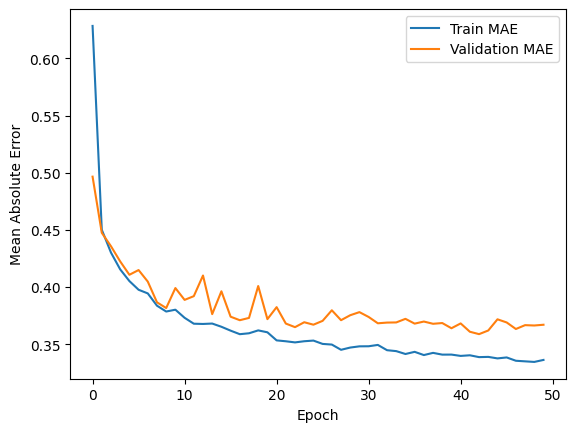

In [ ]:
# Plot training history
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()



- **Data Preparation:** We loaded the California Housing dataset, split it into training and test sets, and scaled the features.
- **Model Creation:** We built a simple feedforward neural network with two hidden layers.
- **Training:** We trained the model for 50 epochs and monitored its performance using validation data.
- **Evaluation:** We evaluated the model on the test set and visualized the results to understand its performance.



In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [5]:
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = layers.Dense(20, activation='tanh')
        self.dense2 = layers.Dense(20, activation='tanh')
        self.dense3 = layers.Dense(20, activation='tanh')
        self.out = layers.Dense(1)

    def call(self, inputs):
        x, t = inputs[:, 0:1], inputs[:, 1:2]
        x = self.dense1(tf.concat([x, t], axis=1))
        x = self.dense2(x)
        x = self.dense3(x)
        return self.out(x)



In [6]:
def physics_informed_loss(model, x, t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(t)
        u = model(tf.concat([x, t], axis=1))
        u_x = tape.gradient(u, x)
    u_xx = tape.gradient(u_x, x)
    u_t = tape.gradient(u, t)
    del tape

    residual = u_t - alpha * u_xx  # Heat equation residual
    return tf.reduce_mean(tf.square(residual))


In [7]:
# Parameters
alpha = 0.01  # Thermal diffusivity

# Generate synthetic data (small sample for demonstration)
x_data = np.linspace(0, 1, 100)
t_data = np.linspace(0, 1, 100)
x_data, t_data = np.meshgrid(x_data, t_data)
x_data = x_data.flatten()[:, None]
t_data = t_data.flatten()[:, None]

# True solution (initial condition for u(x,0) = sin(pi * x))
u_data = np.sin(np.pi * x_data) * np.exp(-np.pi**2 * alpha * t_data)


In [8]:
# Create model instance
pinn = PINN()

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Training loop
epochs = 1000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        loss = physics_informed_loss(pinn, tf.convert_to_tensor(x_data, dtype=tf.float32),
                                           tf.convert_to_tensor(t_data, dtype=tf.float32))
    gradients = tape.gradient(loss, pinn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, pinn.trainable_variables))

    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.numpy()}')


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch: 0, Loss: 0.5608168244361877
Epoch: 100, Loss: 0.000383663282264024
Epoch: 200, Loss: 0.00020285160280764103
Epoch: 300, Loss: 0.00013175353524275124
Epoch: 400, Loss: 8.743416401557624e-05
Epoch: 500, Loss: 5.6052787840599194e-05
Epoch: 600, Loss: 3.452452438068576e-05
Epoch: 700, Loss: 2.0545063307508826e-05
Epoch: 800, Loss: 1.1974589142482728e-05
Epoch: 900, Loss: 7.0205560405156575e-06


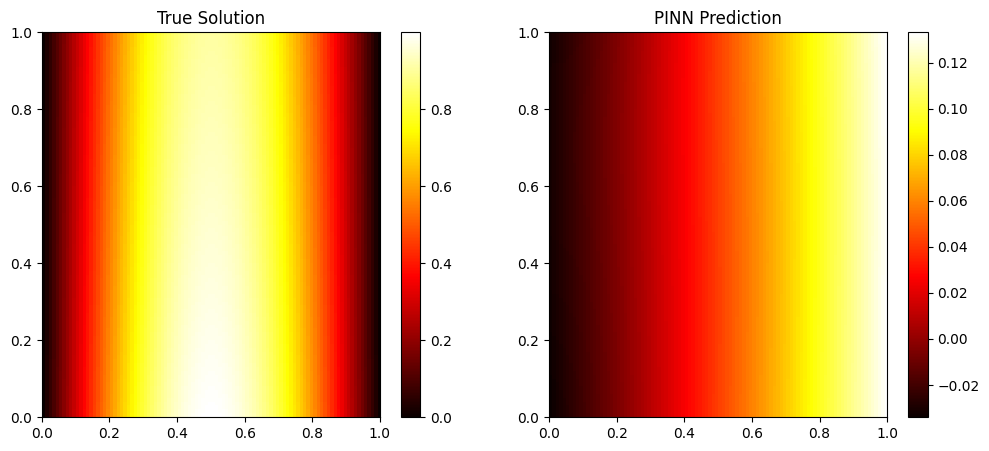

In [9]:
# Predict using the trained model
u_pred = pinn(tf.concat([x_data, t_data], axis=1))

# Reshape for plotting
u_pred = u_pred.numpy().reshape(100, 100)
u_true = u_data.reshape(100, 100)

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("True Solution")
plt.imshow(u_true, cmap='hot', extent=[0, 1, 0, 1], origin='lower', aspect='auto')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("PINN Prediction")
plt.imshow(u_pred, cmap='hot', extent=[0, 1, 0, 1], origin='lower', aspect='auto')
plt.colorbar()

plt.show()
